In [313]:
import os
import cv2
import torch
from torchvision import transforms
from prototypical_net import ConvNet
from PIL import Image
import random
from detect_object_multiscale import detect_object_multiscale

In [314]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch_sizes=[84, 96, 112, 128]
stride=20
extensions=(".jpg", ".jpeg", ".png")
# Load model
model = ConvNet().to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()


ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1

### Transforms

In [315]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [ ]:
workspace_path = "images/workspace-images/workspace15.png"
target_class = "apple"  # Change this to the desired class
support_dir = os.path.join("images/train-images", target_class)
support_path = random.choice([
    os.path.join(support_dir, f)
    for f in os.listdir(support_dir)
    if f.lower().endswith(extensions)
])

# Pick one random image from the class folder
sample_img_path = random.choice([
    os.path.join(support_dir, f) for f in os.listdir(support_dir) if f.endswith(extensions)
])
sample_img = Image.open(sample_img_path).convert("RGB")
sample_tensor = transform(sample_img).unsqueeze(0).to(device)
sample_embedding = model(sample_tensor)

# Load and process workspace image
workspace = cv2.imread(workspace_path)
workspace = cv2.cvtColor(workspace, cv2.COLOR_BGR2RGB)

In [317]:
result = detect_object_multiscale(
    model=model,
    support_path=support_path,
    workspace_path=workspace_path,
    patch_sizes=patch_sizes,
    stride=stride,
    device=device,
    distance=10,
    threshold=0.0,
    confidence=0.0
)
result
# Print the results
# print(f"Best match at: {result['location']}, Distance: {result['distance']:.4f}, Patch Size: {result['patch_size']}, Confidence: {result['confidence']:.4f}")


[{'location': (242, 182),
  'distance': 8.426118850708008,
  'patch_size': 84,
  'confidence': 0.10608820192468597},
 {'location': (622, 502),
  'distance': 8.450955390930176,
  'patch_size': 84,
  'confidence': 0.10580940853447184},
 {'location': (182, 82),
  'distance': 8.687150001525879,
  'patch_size': 84,
  'confidence': 0.10322953601859002},
 {'location': (122, 462),
  'distance': 8.745935440063477,
  'patch_size': 84,
  'confidence': 0.10260687710788764},
 {'location': (722, 102),
  'distance': 8.805962562561035,
  'patch_size': 84,
  'confidence': 0.10197876991882261},
 {'location': (442, 82),
  'distance': 8.858266830444336,
  'patch_size': 84,
  'confidence': 0.10143770879804108},
 {'location': (342, 442),
  'distance': 9.200346946716309,
  'patch_size': 84,
  'confidence': 0.09803588105617521},
 {'location': (522, 302),
  'distance': 9.304683685302734,
  'patch_size': 84,
  'confidence': 0.09704325048097016}]

In [318]:
print(f"Number of detected objects: {len(result)}")

Number of detected objects: 8


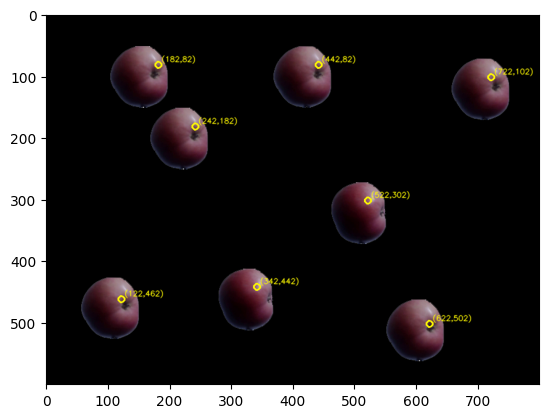

In [319]:
from matplotlib import pyplot as plt

detected = "images/detected.png"
os.remove(detected) if os.path.exists(detected) else None
if result == []:
    print("Object not detected on the workspace.")
else:
    for loc in result:
        x, y = loc['location']
        cv2.circle(workspace, (x, y), 5, (255, 250, 0), 2)
        # Write coordinates near the circle
        text = f"({x},{y})"
        cv2.putText(workspace, text, (x + 5, y - 5), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=0.4, color=(255, 250, 0), thickness=1, lineType=cv2.LINE_AA)
    cv2.imwrite(detected, cv2.cvtColor(workspace, cv2.COLOR_RGB2BGR))
    plt.imshow(workspace)